

 # 归一化层 (Normalization Layers)

 本教程演示专为神经算子（Neural Operators）设计的归一化层。 归一化对于神经网络训练至关重要，原因包括：

 - 稳定训练动态（避免梯度爆炸/消失）

 - 加速收敛速度

 - 提升模型泛化能力

 - 处理不同的数据分布


 教程涵盖 `InstanceNorm`、`BatchNorm` 和 `AdaIN` 三种归一化层， 这些层与维度无关，可灵活适配各类神经算子架构。


 ## 导入依赖库

 导入使用归一化层所需的核心模块



In [1]:
# 导入PyTorch核心库，用于构建和训练神经网络
import torch
# 导入PyTorch神经网络模块，包含各类层和激活函数
import torch.nn as nn
# 导入matplotlib绘图库，用于可视化数据和归一化效果
import matplotlib.pyplot as plt
# 导入numpy库，用于生成随机数和数值计算
import numpy as np

# 从neuralop库导入专为神经算子设计的归一化层
from neuralop.layers.normalization_layers import InstanceNorm, BatchNorm, AdaIN

# 设置计算设备：优先使用GPU（CUDA），若无则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


尝试打开的路径是: c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages
尝试打开的路径是: c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages




 ## 用一维函数理解归一化

 为清晰展示各类归一化层的工作原理，我们生成一维函数的合成数据集。批次包含10个函数：

 - 前5个：高振幅、正垂直偏移的正弦波

 - 后5个：低振幅、负垂直偏移的余弦波



In [2]:
# 定义样本数量（函数个数）
n_samples = 10
# 定义每个函数的采样点数量
n_points = 100
# 生成0到2π之间的100个等距采样点（x轴数据）
x = torch.linspace(0, 2 * torch.pi, n_points)
# 初始化数据张量：形状为 [样本数, 通道数, 采样点数]，符合神经网络输入格式
data = torch.zeros((n_samples, 1, n_points))

# 生成两组具有不同统计特征的函数
for i in range(n_samples):
    if i < 5:
        # 第一组：高振幅正弦波 + 正垂直偏移
        # 随机生成振幅（2.0~3.0之间）
        amplitude = np.random.uniform(2.0, 3.0)
        # 随机生成垂直偏移（1.0~2.0之间）
        shift = np.random.uniform(1.0, 2.0)
        # 随机生成频率（2.0~3.0之间）
        frequency = np.random.uniform(2.0, 3.0)
        # 生成正弦波并赋值到数据张量中
        data[i, 0, :] = amplitude * torch.sin(frequency * x) + shift
    else:
        # 第二组：低振幅余弦波 + 负垂直偏移
        # 随机生成振幅（0.5~1.0之间）
        amplitude = np.random.uniform(0.5, 1.0)
        # 随机生成垂直偏移（-2.0~-1.0之间）
        shift = np.random.uniform(-2.0, -1.0)
        # 随机生成频率（1.0~2.0之间）
        frequency = np.random.uniform(1.0, 2.0)
        # 生成余弦波并赋值到数据张量中
        data[i, 0, :] = amplitude * torch.cos(frequency * x) + shift




 ## 可视化原始数据

 绘制合成函数，观察其不同的统计特性：

 - 蓝色函数：高振幅、正偏移

 - 红色函数：低振幅、负偏移

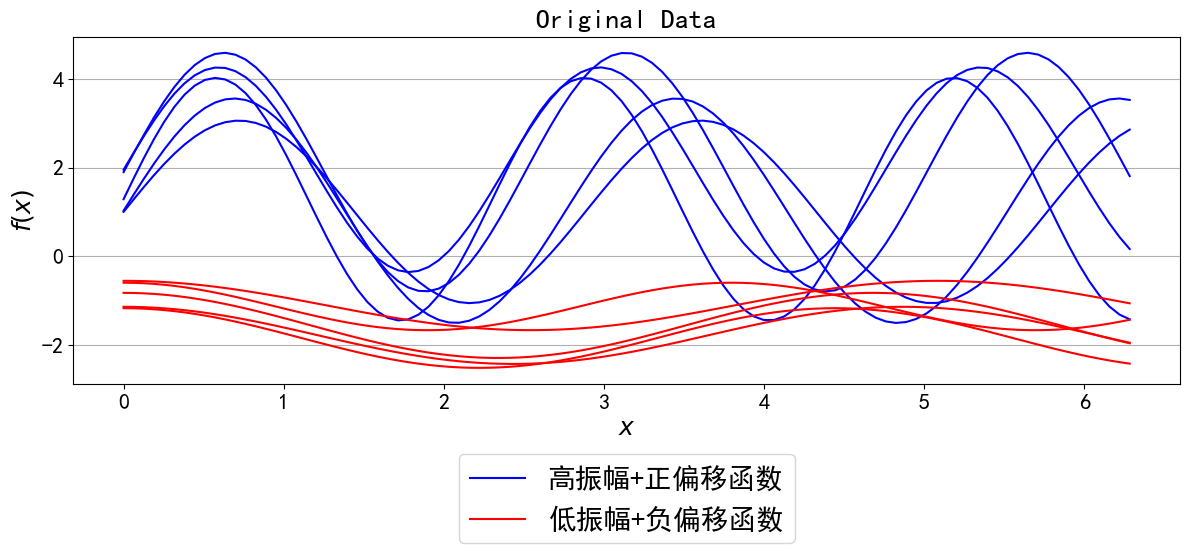

In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei'] # 显示中文
plt.rcParams['axes.unicode_minus'] = False # 正常显示负号
# 创建绘图窗口，设置尺寸为12x6英寸
plt.figure(figsize=(12, 6))
# 设置图表标题，字体大小20
plt.title("Original Data", fontsize=20)
# 遍历所有样本函数
for i in range(n_samples):
    if i < 5:
        # 绘制第一组函数（蓝色实线），仅第一个样本添加图例
        plt.plot(x, data[i, 0, :], "b-", label="高振幅+正偏移函数" if i == 0 else "")
    else:
        # 绘制第二组函数（红色实线），仅第六个样本添加图例
        plt.plot(x, data[i, 0, :], "r-", label="低振幅+负偏移函数" if i == 5 else "")

# 设置图例：字体大小20，位置在底部中心，锚点(0.5, -0.5)，1列显示
plt.legend(fontsize=20, loc="lower center", bbox_to_anchor=(0.5, -0.5), ncol=1)
# 设置x轴标签，字体大小18
plt.xlabel("$x$", fontsize=18)
# 设置y轴标签，字体大小18
plt.ylabel("$f(x)$", fontsize=18)
# 设置x轴刻度字体大小16
plt.xticks(fontsize=16)
# 设置y轴刻度字体大小16
plt.yticks(fontsize=16)
# 设置y轴刻度数量为5个
plt.locator_params(axis="y", nbins=5)
# 显示y轴网格线
plt.grid(True, axis="y")
# 调整子图边距：底部留20%，顶部留90%
plt.subplots_adjust(bottom=0.2, top=0.9)
# 自动调整布局，避免元素重叠
plt.tight_layout()
# 显示图表
plt.show()






 ## 实例归一化 (InstanceNorm)

 `InstanceNorm` 对批次中的**每个样本独立归一化**。 这意味着它会将10个函数中的每一个都缩放到均值为0、标准差为1，与批次中其他函数无关。 适用于每个样本的统计特性差异显著、需要独立处理的场景。



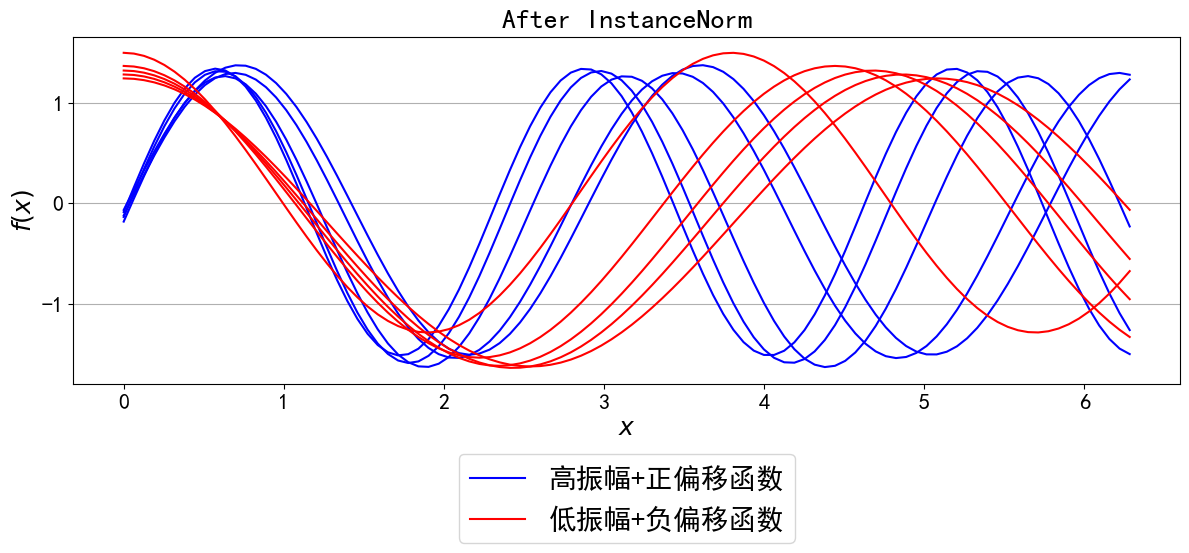

In [4]:
# 实例化InstanceNorm层（无参数，因为是逐样本归一化）
instance_norm = InstanceNorm()
# 对原始数据应用实例归一化
data_in = instance_norm(data)

# 绘制归一化后的结果
plt.figure(figsize=(12, 6))
plt.title("After InstanceNorm", fontsize=20)
for i in range(n_samples):
    # 将张量转换为numpy数组（detach避免计算图干扰）
    y_plot = data_in[i, 0, :].detach().numpy()
    if i < 5:
        plt.plot(x, y_plot, "b-", label="高振幅+正偏移函数" if i == 0 else "")
    else:
        plt.plot(x, y_plot, "r-", label="低振幅+负偏移函数" if i == 5 else "")
# 图例和坐标轴设置与原始数据一致
plt.legend(fontsize=20, loc="lower center", bbox_to_anchor=(0.5, -0.5), ncol=1)
plt.xlabel("$x$", fontsize=18)
plt.ylabel("$f(x)$", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.locator_params(axis="y", nbins=5)
plt.grid(True, axis="y")
plt.subplots_adjust(bottom=0.2, top=0.9)
plt.tight_layout()
plt.show()




 可以看到，所有函数都被缩放到相同范围（均值0，标准差1）， 函数间原本的振幅和偏移差异被完全消除——这是逐样本归一化的核心特征。


 ## 批次归一化 (BatchNorm)

 `BatchNorm` 对**整个批次的数据归一化**。

 它计算10个函数的整体均值和标准差，并用这些值归一化所有数据。 这是最常用的归一化方式，适用于批次统计能近似整体数据分布的场景。



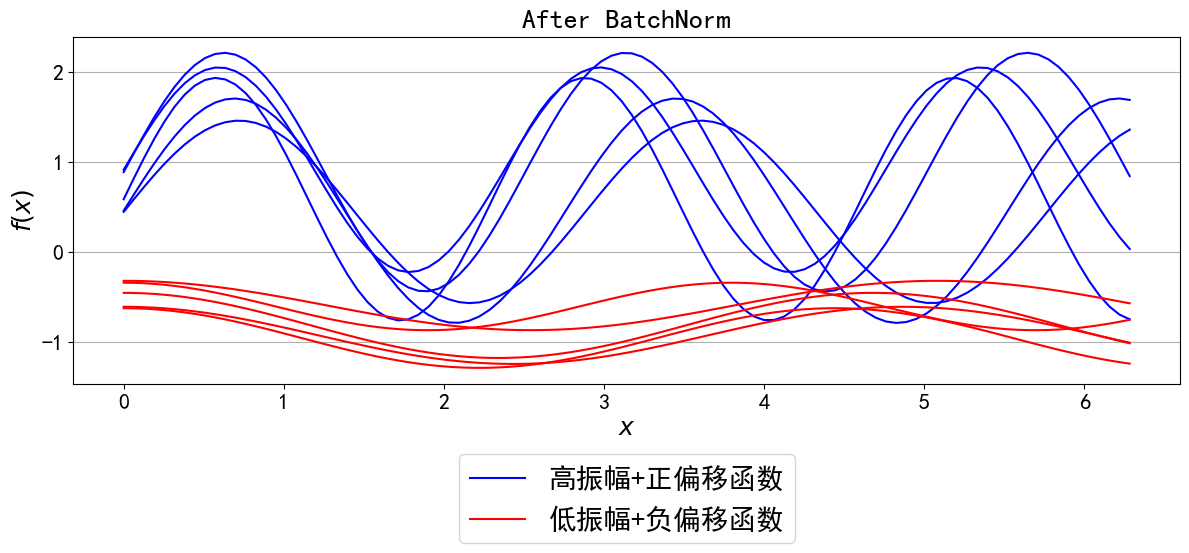

In [5]:
# 实例化BatchNorm层：n_dim=1（一维数据），num_features=1（输入通道数）
batch_norm = BatchNorm(n_dim=1, num_features=1)
# 对原始数据应用批次归一化
data_bn = batch_norm(data)

# 绘制批次归一化后的结果
plt.figure(figsize=(12, 6))
plt.title("After BatchNorm", fontsize=20)
for i in range(n_samples):
    y_plot = data_bn[i, 0, :].detach().numpy()
    if i < 5:
        plt.plot(x, y_plot, "b-", label="高振幅+正偏移函数" if i == 0 else "")
    else:
        plt.plot(x, y_plot, "r-", label="低振幅+负偏移函数" if i == 5 else "")
# 图例和坐标轴设置与之前一致
plt.legend(fontsize=20, loc="lower center", bbox_to_anchor=(0.5, -0.5), ncol=1)
plt.xlabel("$x$", fontsize=18)
plt.ylabel("$f(x)$", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.locator_params(axis="y", nbins=5)
plt.grid(True, axis="y")
plt.subplots_adjust(bottom=0.2, top=0.9)
plt.tight_layout()
plt.show()


 `BatchNorm` 保留了两组函数间的相对差异： 高振幅函数仍与低振幅函数有明显区别，但整个批次的均值被拉到0，标准差被缩放到1。





 ## 自适应实例归一化 (AdaIN, Adaptive Instance Normalization)

 AdaIN 是更高级的归一化方式，支持“风格迁移”：

 1. 先对输入做实例归一化（和InstanceNorm一样）

 2. 再基于外部嵌入向量（embedding）生成的缩放因子（weight）和偏移因子（bias）调整输出

 适用于需要通过条件信号控制输出特征的场景（如风格迁移、条件生成）。 为保证教程结果清晰可复现，我们自定义一个简单的MLP， 直接将风格嵌入向量映射为所需的weight和bias。



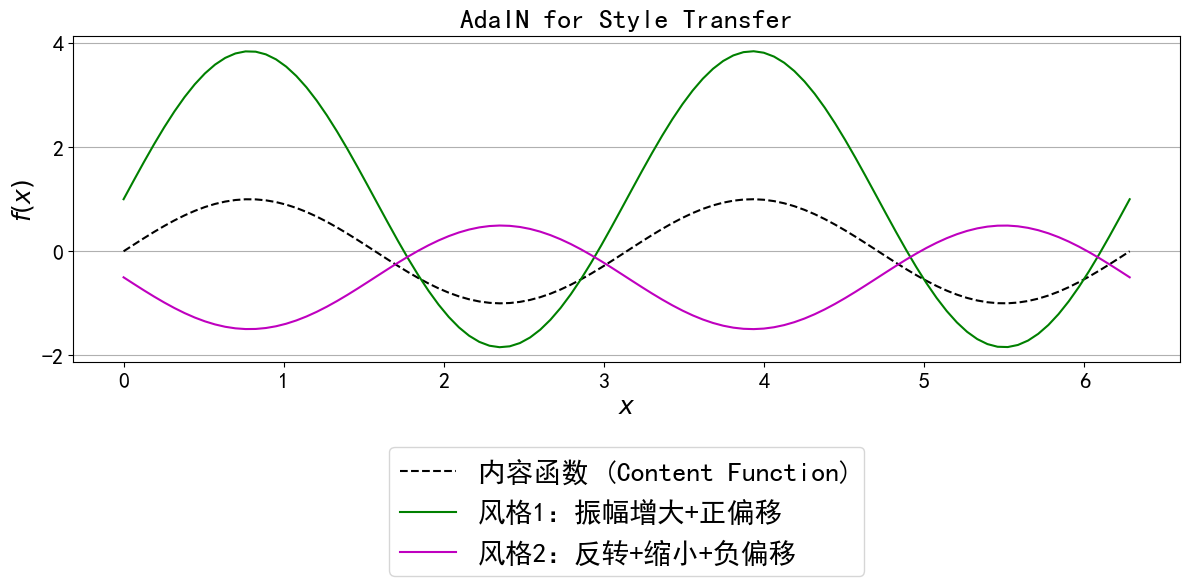

In [6]:
# 定义内容函数：sin(2x)，形状调整为 [1, 1, 100]（批次大小=1，通道数=1，采样点数=100）
content_function = torch.sin(2 * x).unsqueeze(0).unsqueeze(0)  # (1, 1, 100)


# 自定义简单的MLP（仅前向传播，无隐藏层）：直接返回嵌入向量作为(weight, bias)
# 目的：完全控制风格参数，便于演示AdaIN的效果
class ToyMLP(nn.Module):
    def forward(self, embedding):
        # 输入：风格嵌入向量 [weight, bias]
        # 输出：直接返回嵌入向量（作为AdaIN的缩放和偏移参数）
        return embedding


# 风格1：简单的振幅和均值调整（weight=2.0：振幅放大2倍，bias=1.0：整体上移1）
style_embedding_1 = torch.tensor([2.0, 1.0])
# 风格2：复杂变换（weight=-0.7：振幅缩小+反转相位，bias=-0.5：整体下移0.5）
style_embedding_2 = torch.tensor([-0.7, -0.5])

# 实例化AdaIN层：
# - embed_dim=2：风格嵌入向量的维度（对应weight和bias）
# - in_channels=1：输入数据的通道数
# - mlp=ToyMLP()：自定义的风格映射网络
adain = AdaIN(embed_dim=2, in_channels=1, mlp=ToyMLP())

# 应用风格1到内容函数
adain.set_embedding(style_embedding_1)  # 设置当前风格嵌入向量
output_1 = adain(content_function)      # 前向传播得到风格1的输出

# 应用风格2到内容函数
adain.set_embedding(style_embedding_2)  # 切换风格嵌入向量
output_2 = adain(content_function)      # 前向传播得到风格2的输出

# 绘制AdaIN风格迁移效果
plt.figure(figsize=(12, 6))
plt.title("AdaIN for Style Transfer", fontsize=20)
# 绘制原始内容函数（黑色虚线）
plt.plot(x, content_function.squeeze().numpy(), "k--", label="内容函数 (Content Function)")
# 绘制风格1的输出（绿色实线）
plt.plot(x, output_1.squeeze().detach().numpy(), "g-", label="风格1：振幅增大+正偏移")
# 绘制风格2的输出（紫色实线）
plt.plot(x, output_2.squeeze().detach().numpy(), "m-", label="风格2：反转+缩小+负偏移")
# 调整图例位置（留出更多底部空间）
plt.legend(fontsize=20, loc="lower center", bbox_to_anchor=(0.5, -0.7), ncol=1)
plt.xlabel("$x$", fontsize=18)
plt.ylabel("$f(x)$", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.locator_params(axis="y", nbins=5)
plt.grid(True, axis="y")
plt.subplots_adjust(bottom=0.35, top=0.9)
plt.tight_layout()
plt.show()




 可以看到，相同的内容函数被转换为两种完全不同的输出：

 - 风格1：生成振幅更大、整体上移的正弦波

 - 风格2：生成相位反转、振幅缩小、整体下移的波形

 这体现了AdaIN如何基于风格嵌入向量灵活调制网络输出的特性。